# Spatial Transcriptomics Analysis

In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set()

2024-10-23 06:44:23.602738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 06:44:23.618240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 06:44:23.622869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 06:44:24.602377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.8, Tutorials: https://omicverse.readthedocs.io/
Dependency error: (pydeseq2 0.4.1 (/opt/miniforge/envs/omicverse/lib/python3.10/site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))


In [2]:
adata_spatial = sc.read_h5ad('Gastric/Spatial/H5ad/gc18.h5ad')
adata_spatial

AnnData object with n_obs × n_vars = 1385 × 18031
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col'
    uns: 'spatial'
    obsm: 'spatial'

# Annotation

In [3]:
adata_spatial.uns['spatial']['gc18']['scalefactors'] = {'spot_diameter_fullres': 1,
                                                 'tissue_hires_scalef': 0.143472,
                                                 'fiducial_diameter_fullres': 224.5717,
                                                 'tissue_lowres_scalef': 0.04304161}

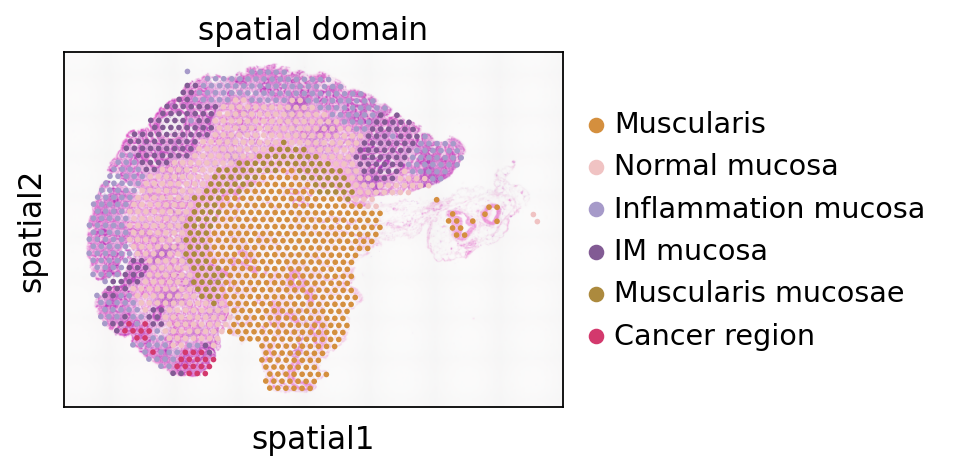

In [4]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    'C0': 'Muscularis',
    'C1': 'Normal mucosa',
    'C2': 'Inflammation mucosa',
    'C3': 'IM mucosa',
    'C4': 'Muscularis mucosae',
    'C5': 'Cancer region',
 
}
adata_spatial.obs['spatial domain'] = adata_spatial.obs['seurat_clusters'].map(cluster2annotation).astype('category')
sc.pl.spatial(adata_spatial,img_key="lowres", color="spatial domain",
              palette=[ov.utils.orange_color[1]]+ov.pl.sc_color[14:14]+\
              ov.utils.red_color[0:1]+ov.pl.purple_color[4:5]+ov.pl.purple_color[1:2]+[ov.utils.orange_color[2]]+ov.pl.red_color[5:6],
              spot_size=224.5717/1.5)

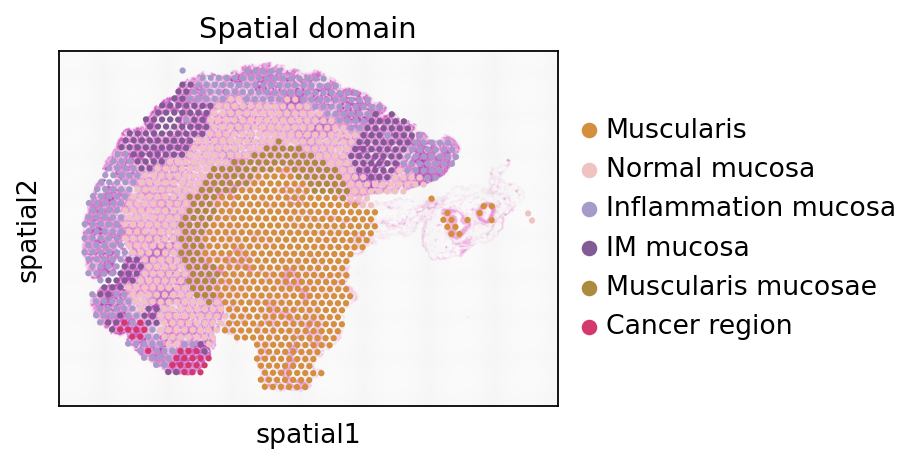

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))

ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
              color=['spatial domain'], colorbar_loc=None,
              ncols=3, spot_size=224.5717/1.35,legend_fontsize=12,
              img_key='lowres',ax=ax,show=False
             )  
ax[0].set_title('Spatial domain', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial2', fontsize=12)

fig.savefig(f'Gastric/Figure/Spatial_main/spatial_domain.png', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
type_color_all ={
    'Muscularis':[ov.utils.orange_color[1]][0],
    'Normal mucosa':ov.utils.red_color[0:1][0], 
    'Inflammation mucosa':ov.pl.purple_color[4:5][0],
    'Intestinal metaplasia  mucosa':ov.pl.purple_color[1:2][0],
    'Muscularis mucosa':[ov.utils.orange_color[2]][0],
    'Cancer region':ov.pl.red_color[5:6][0],
}

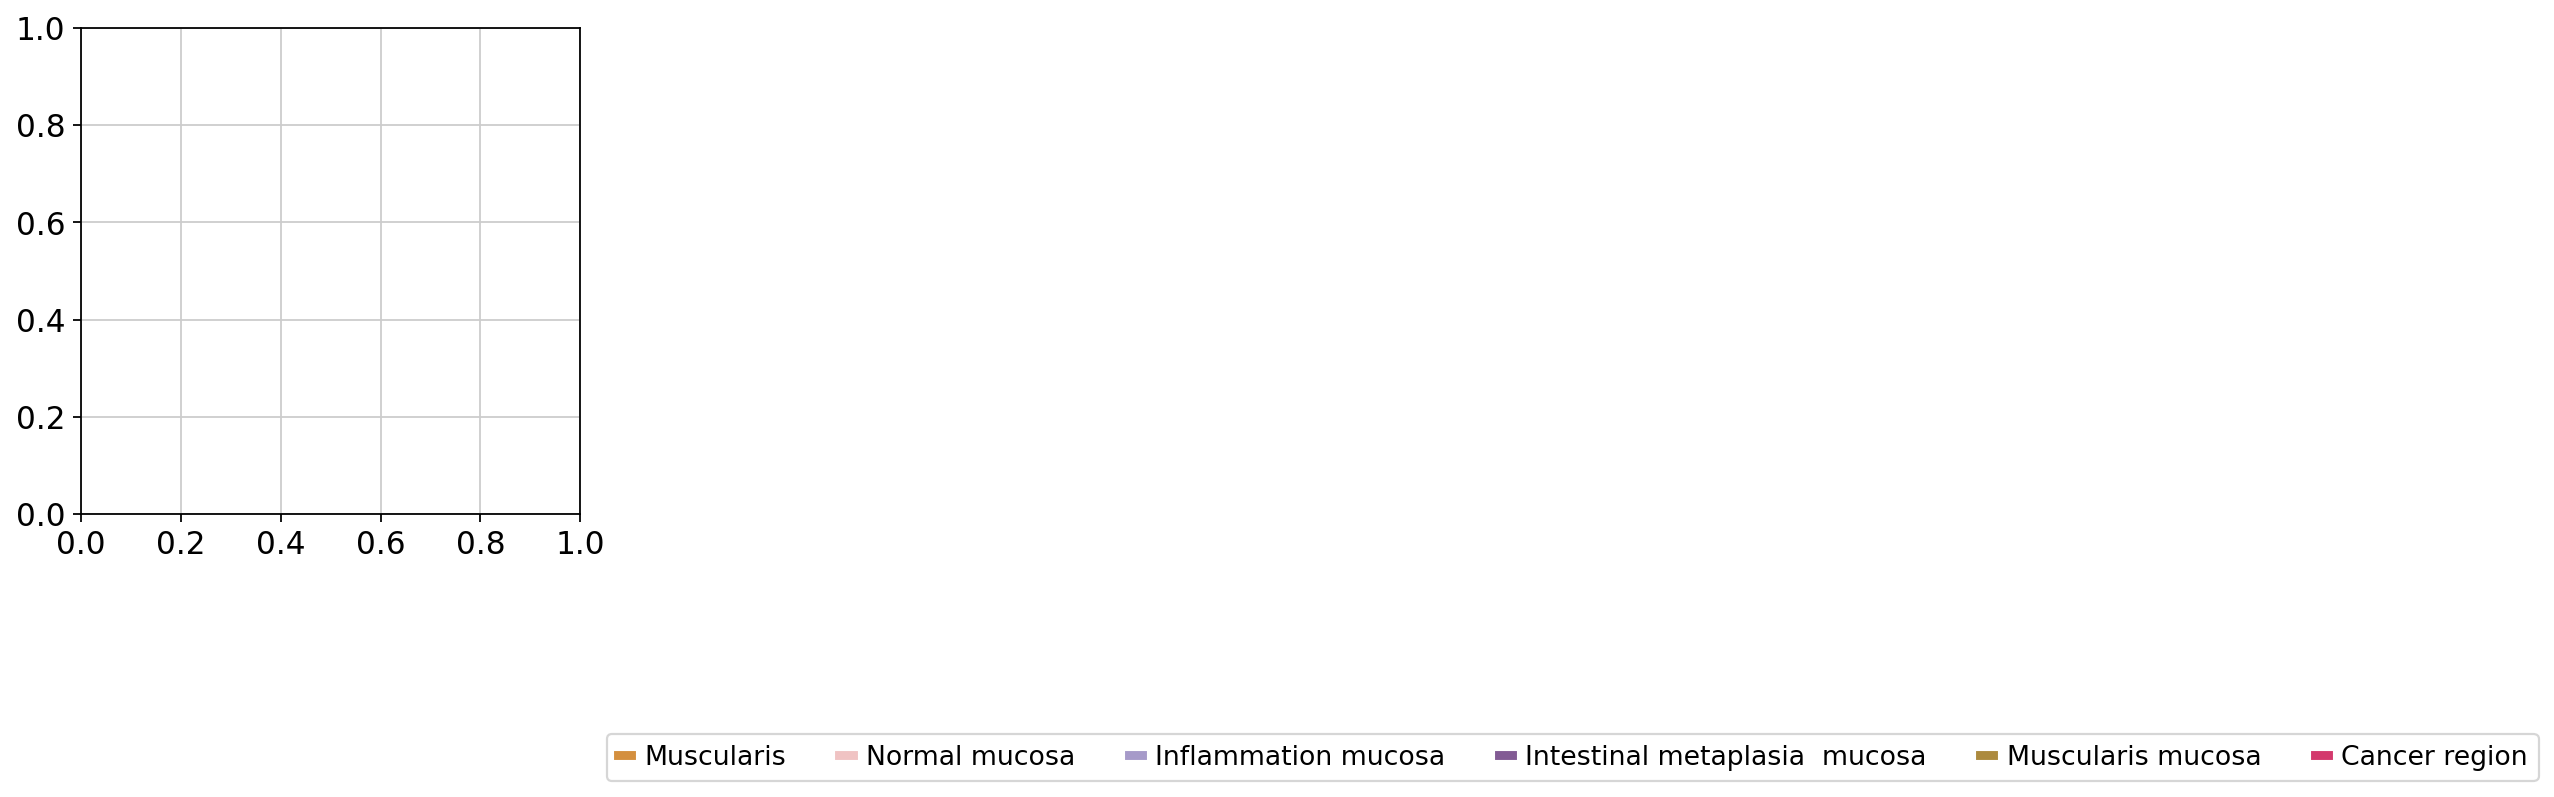

In [9]:
groupby = 'major_celltype'
#type_color_all = dict(zip(adata.obs[groupby].cat.categories, adata.uns[f"{groupby}_colors"]))
handles = [plt.Line2D([0], [0], color=type_color_all[cell], lw=4) for cell in type_color_all.keys()]
labels = type_color_all.keys()

ncols = 6

# Add a legend to the right of the existing image
legend_kws = {'fontsize': 12, 'bbox_to_anchor':(1, -0.5),
              'loc': 'center left', 'ncol': ncols}
plt.legend(handles, labels, borderaxespad=1, handletextpad=0.5, labelspacing=0.2, **legend_kws)
plt.savefig('Gastric/Figure/Spatial_main/legend.png', dpi=300, bbox_inches='tight')

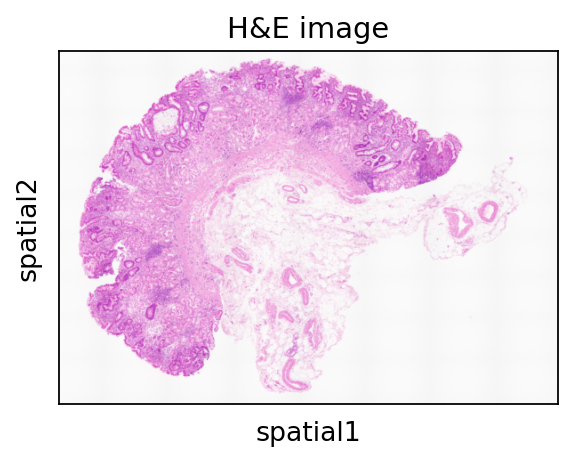

In [10]:
import scanpy as sc
import matplotlib.pyplot as plt





fig, ax = plt.subplots(figsize=(4, 4))

# 在这个图形对象上绘制空间图
ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
              color=['spatial domain'], colorbar_loc=None,legend_loc=None,
              ncols=3, spot_size=0,legend_fontsize=12,title='H&E images',
              img_key='lowres',ax=ax,show=False,
             )  # 使用 ax 参数指定绘图轴
ax[0].set_title('H&E image', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial2', fontsize=12)


fig.savefig(f'Gastric/Figure/Spatial_main/HE.png', dpi=300, bbox_inches='tight')


plt.show()

# Deconvolution and Marker Gene

In [11]:
adata_rna = sc.read('Gastric/Data/Gastric_anno.h5ad')
adata_rna.X.max()

10.0

In [12]:
sc.pp.calculate_qc_metrics(adata_spatial, inplace=True)
#adata = adata[:,adata.var['total_counts']>100]
adata_spatial=ov.pp.preprocess(adata_spatial,mode='shiftlog|pearson',n_HVGs=2000,)
adata_spatial.raw = adata_spatial
adata_spatial = adata_spatial[:, adata_spatial.var.highly_variable_features]
adata_spatial=adata_spatial.copy()
adata_spatial

Begin robust gene identification
After filtration, 18031/18031 genes are kept.     Among 18031 genes, 18031 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'PGC', 'MUC6', 'LYZ']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 3.666867971420288 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 1385 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'spatial', 'spatial domain_colors', 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts'

In [13]:
ct=adata_rna.obs['major_celltype'].value_counts()[adata_rna.obs['major_celltype'].value_counts()>=10].index.tolist()
adata_sc=adata_rna[adata_rna.obs['major_celltype'].isin(ct)]
tg=ov.space.Tangram(adata_rna,adata_spatial,clusters='major_celltype')
tg.train(mode="clusters",num_epochs=500,device="cuda:0")

tangram have been install version: 1.0.4
ranking genes
    finished: added to `.uns['major_celltype_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
...Calculate The Number of Markers: 746


INFO:root:284 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:355 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


...Model prepared successfully


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 284 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.066, KL reg: 0.157
Score: 0.276, KL reg: 0.004
Score: 0.279, KL reg: 0.004
Score: 0.280, KL reg: 0.004
Score: 0.280, KL reg: 0.004


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


...Model train successfully


In [14]:
adata_plot=tg.cell2location()
adata_plot.obs.columns
annotation_list=ct
adata_plot

AnnData object with n_obs × n_vars = 1385 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'uniform_density', 'rna_count_based_density', 'Endocrine cell', 'Mast cell', 'B cell(Plasma cell)', 'Myeloid cell', 'NK/T cell', 'Smooth muscle cell', 'B cell', 'Endothelial cell', 'Fibroblast', 'Neutrophil', 'Epithelial cell'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'n_cells', 'sparsity'
    uns: 'spatial', 'spatial domain_colors', 'log1p', 'hvg', 'training_genes', 'overl

In [15]:
marker_genes_dict = {
    'Epithelial cell':['MUC5AC','MUC1','CDH1',],
    'B cell(Plasma cell)':['MZB1','DERL3','IGKC'],
    'B cell':['CD79A','MS4A1','BANK1'],
    'Endocrine cell':['CHGA','PCSK1N','SCG5'],
    'Myeloid cell':['AIF1','CD68','MS4A7'],
    'Mast cell':['TPSAB1','TPSB2','CPA3'],
    'Fibroblast':['DCN','DPT','PDGFRA'],
    'NK/T cell':['CD2','CD3E','CD7'],
    'Smooth muscle cell':['ACTA2','MYH11','ACTG2'],
    'Endothelial cell':['CLDN5','PECAM1','ACKR1'],
    'Neutrophil':['G0S2','CSF3R','FCGR3B'] 
}
for celltype in marker_genes_dict.keys():
    sc.tl.score_genes(adata_spatial, marker_genes_dict[celltype], score_name=celltype)
adata_spatial

computing score 'Epithelial cell'
    finished: added
    'Epithelial cell', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'B cell(Plasma cell)'
    finished: added
    'B cell(Plasma cell)', score of gene set (adata.obs).
    107 total control genes are used. (0:00:00)
computing score 'B cell'
    finished: added
    'B cell', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'Endocrine cell'
    finished: added
    'Endocrine cell', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'Myeloid cell'
    finished: added
    'Myeloid cell', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'Mast cell'
    finished: added
    'Mast cell', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Fibroblast'
    finished: added
    'Fibroblast', score of gene set (adata.obs

AnnData object with n_obs × n_vars = 1385 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'uniform_density', 'rna_count_based_density', 'Epithelial cell', 'B cell(Plasma cell)', 'B cell', 'Endocrine cell', 'Myeloid cell', 'Mast cell', 'Fibroblast', 'NK/T cell', 'Smooth muscle cell', 'Endothelial cell', 'Neutrophil'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'n_cells', 'sparsity'
    uns: 'spatial', 'spatial domain_colors', 'log1p', 'hvg', 'training_genes', 'overl

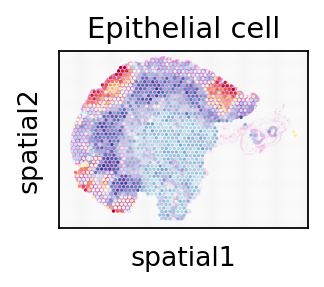

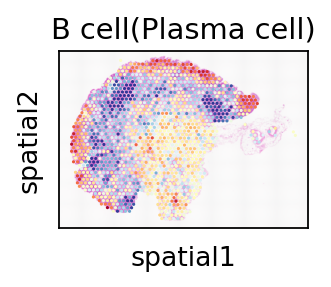

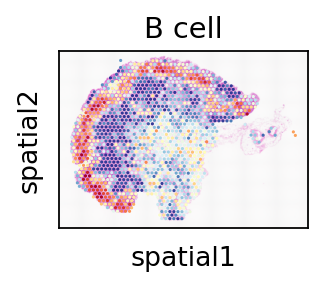

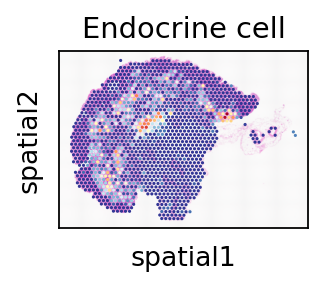

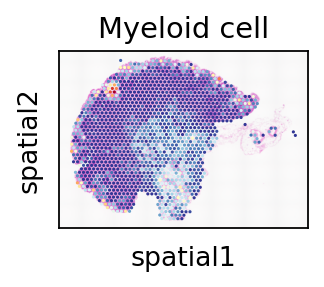

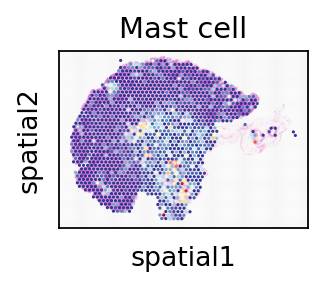

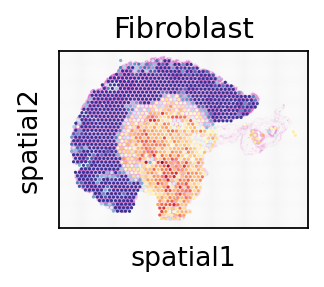

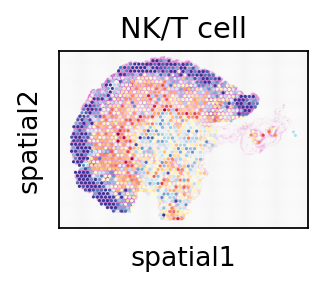

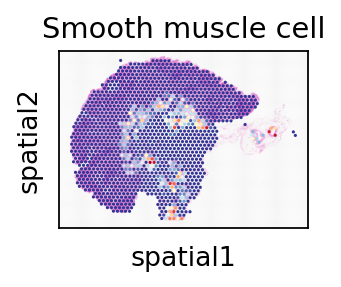

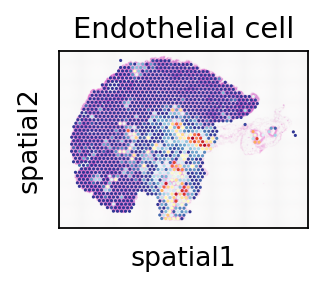

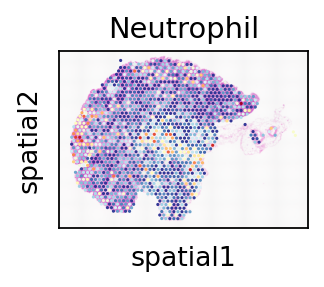

In [16]:
import scanpy as sc
import matplotlib.pyplot as plt



for celltype in marker_genes_dict.keys():
    celltype_no_spaces = celltype.replace(" ", "_")
    celltype_no_spaces = celltype.replace("/","_")
    fig, ax = plt.subplots(figsize=(2, 2))
    
    ax = sc.pl.spatial(adata_plot, cmap='RdYlBu_r',
                  color=[celltype], colorbar_loc=None,
                  ncols=3, spot_size=224.5717/1.35,
                  img_key='lowres',ax=ax,legend_fontsize=12,show=False
                 )  
    ax[0].set_title(celltype, fontsize=13)
    ax[0].set_xlabel('spatial1', fontsize=12)
    ax[0].set_ylabel('spatial2', fontsize=12)
    
    fig.savefig(f'Gastric/Figure/Spatial_main/{celltype_no_spaces}_deconvolution.png', dpi=300, bbox_inches='tight')
    
    plt.show(),

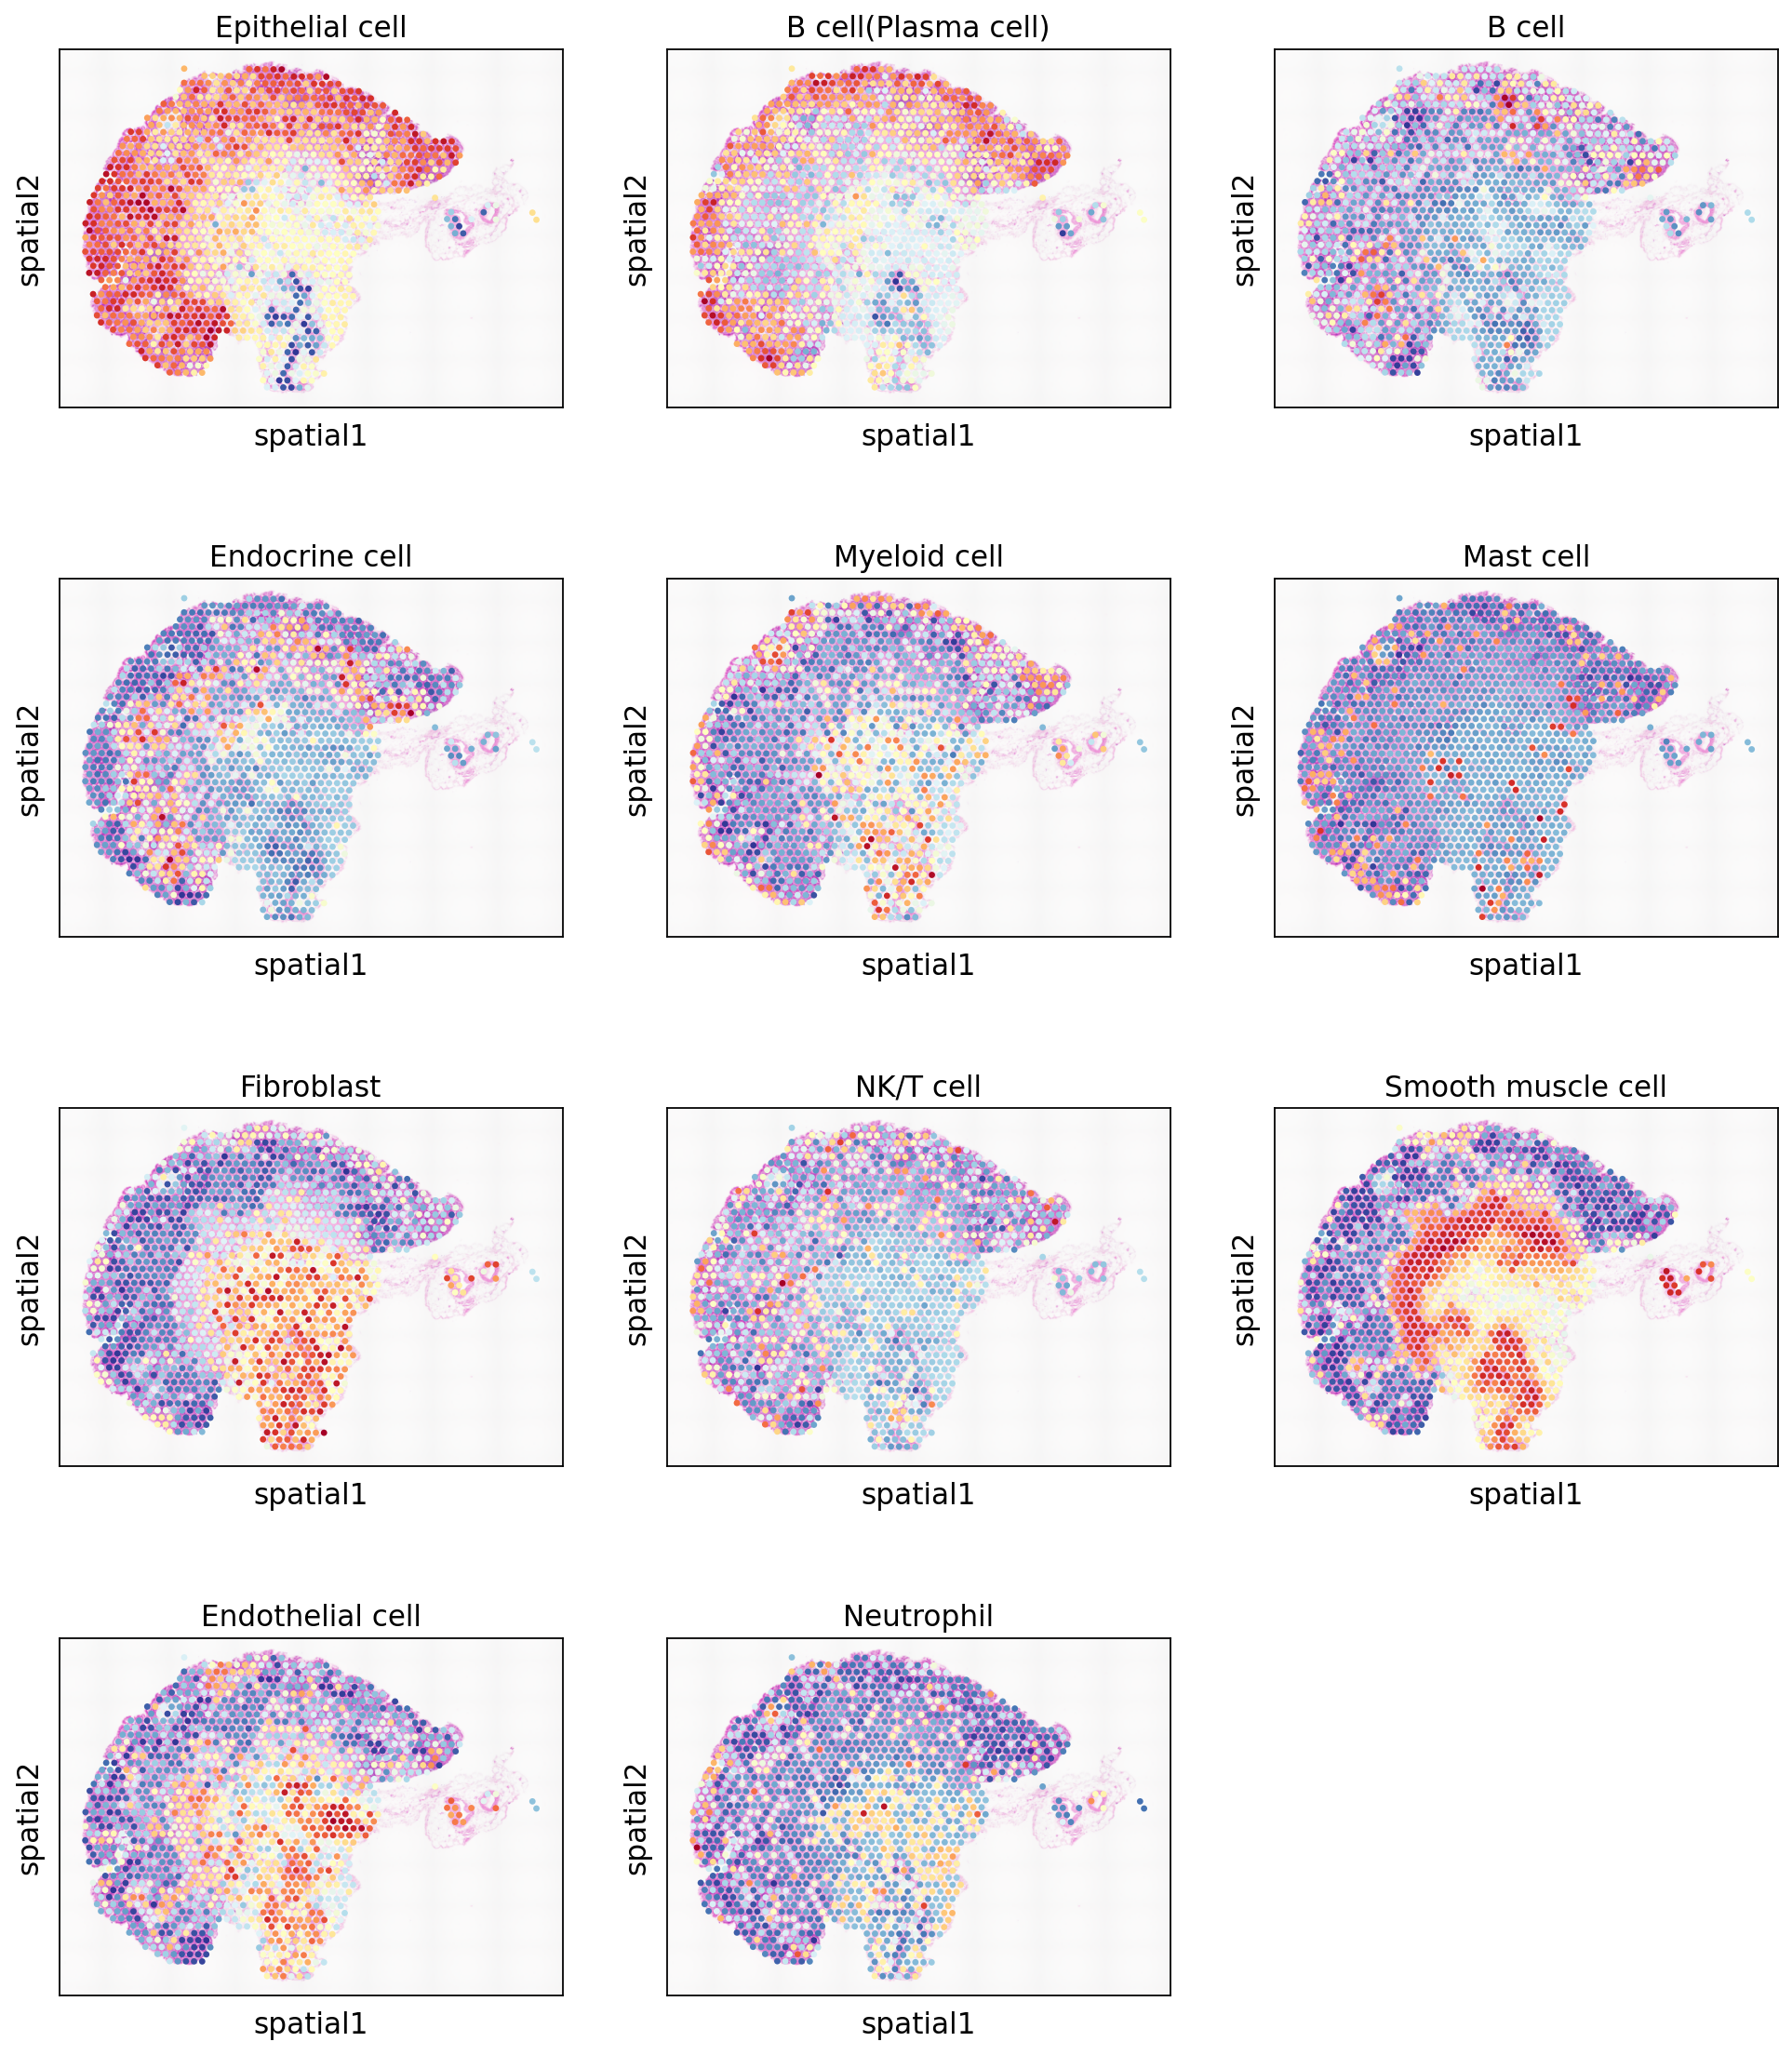

In [17]:
sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=marker_genes_dict.keys(),colorbar_loc=None,
                  ncols=3, spot_size=224.5717/1.35,outline_width=0.02,legend_loc=None,
                  img_key='lowres',
                 )

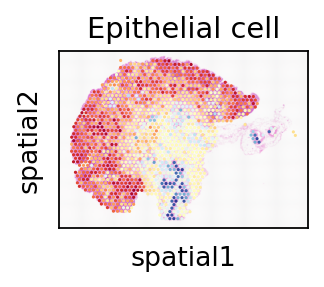

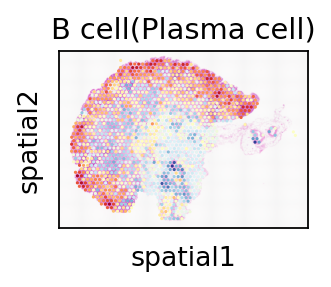

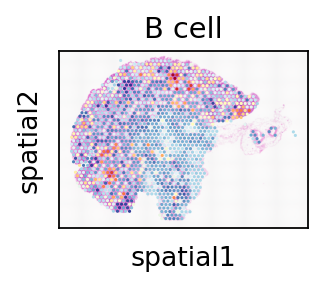

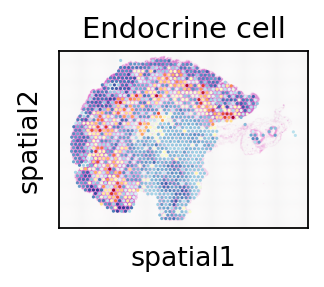

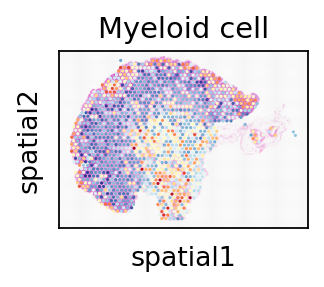

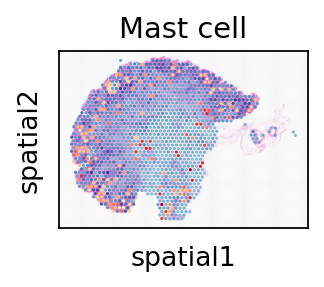

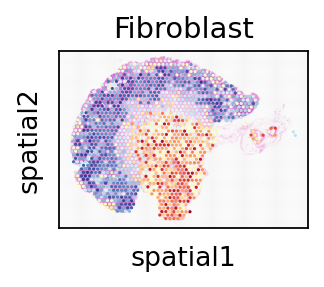

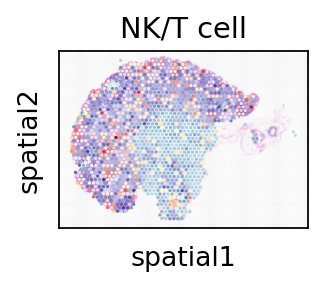

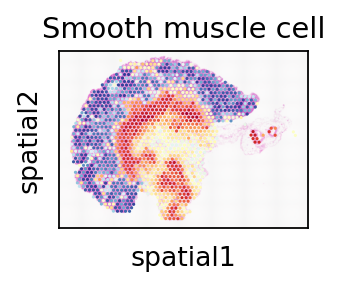

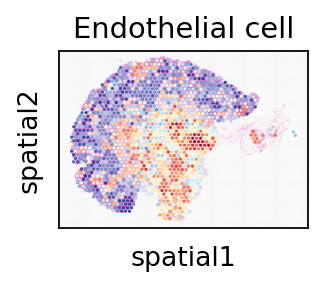

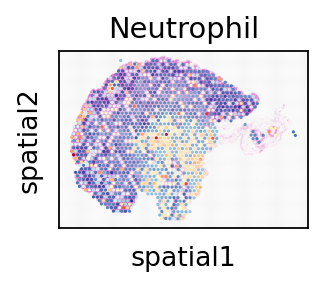

In [19]:
import scanpy as sc
import matplotlib.pyplot as plt



for celltype in marker_genes_dict.keys():
    celltype_no_spaces = celltype.replace(" ", "_")
    celltype_no_spaces = celltype.replace("/","_")
    fig, ax = plt.subplots(figsize=(2, 2))
    
    ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=[celltype], colorbar_loc=None,
                  ncols=3, spot_size=224.5717/1.35,
                  img_key='lowres',ax=ax,legend_fontsize=12,show=False
                 )  
    ax[0].set_title(celltype, fontsize=13)
    ax[0].set_xlabel('spatial1', fontsize=12)
    ax[0].set_ylabel('spatial2', fontsize=12)

    
    fig.savefig(f'Gastric/Figure/Spatial_main/{celltype_no_spaces}_markergene.png', dpi=300, bbox_inches='tight')
    
    plt.show(),

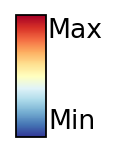

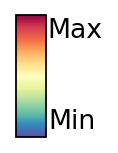

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_color_bar(camp='', pathway=''):
    data = np.linspace(0, 1, 100).reshape(1, -1)
    max_value = np.max(data)
    min_value = 0
    max_label = 2.5  
    
    colormap = mpl.cm.get_cmap(camp)

    fig, ax = plt.subplots(figsize=(0.25, 1)) 

    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_label)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=colormap, norm=norm, orientation='vertical')  #

   # cb.ax.set_title('Gene Expression', fontsize=20, pad=12)

    cb.ax.text(1.85, 0.05, 'Min', ha='center', va='bottom', fontsize=12)
    cb.ax.text(1.95, 2.45, 'Max', ha='center', va='top', fontsize=12)
    
    fig.subplots_adjust(left=0.2)
    
    cb.ax.set_yticks([])
    if pathway is not None:
        plt.savefig(pathway, dpi=300, bbox_inches='tight')
    #plt.show()

# 使用示例
plot_color_bar('RdYlBu_r','Gastric/Figure/Spatial_main/colorbar_RdYlBu_r.png')  
plot_color_bar('Spectral_r','Gastric/Figure/Spatial_main/colorbar_Spectral_r.png') 

# T cell anaylsis 

## Pathway

In [25]:
set(adata_spatial.obs['spatial domain'])
adata_spatial_part = adata_spatial[adata_spatial.obs['spatial domain'].isin(['Inflammation mucosa','Normal mucosa','IM mucosa'])]
adata_spatial_part

View of AnnData object with n_obs × n_vars = 780 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'uniform_density', 'rna_count_based_density', 'Epithelial cell', 'B cell(Plasma cell)', 'B cell', 'Endocrine cell', 'Myeloid cell', 'Mast cell', 'Fibroblast', 'NK/T cell', 'Smooth muscle cell', 'Endothelial cell', 'Neutrophil', 'Score of epithelial structure maintenance pathway', 'CD8_Tex', 'CD8_MAIT', 'CD4_Th17', 'CD4_Treg', 'Exhuasted Score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_v

computing score 'Score of cytokine-mediated\nsignaling pathway'
       'HLA-DRB1', 'HLA-DQB1', 'LIMS1', 'HLA-DQB2', 'RPS27A', 'HLA-DQA2',
       'HLA-DQA1', 'PSMA6', 'HLA-DPB1', 'RPLP0', 'H3C13', 'HLA-DPA1', 'IL6ST',
       'IFNA17', 'GPR75', 'IFNA10', 'EIF5A', 'HLA-DRA', 'BOLA2', 'CDC42',
       'HLA-C', 'HLA-A', 'HLA-B', 'IL17RE', 'HLA-G', 'HLA-E', 'HLA-F', 'SKP1',
       'DUOX1', 'RAP1B', 'H3C1', 'SAA1', 'CCL4L1', 'ALOX15', 'CASP1',
       'RPS6KA5', 'RPS6KA4'],
      dtype='object')
    finished: added
    'Score of cytokine-mediated\nsignaling pathway', score of gene set (adata.obs).
    1163 total control genes are used. (0:00:00)
computing score 'Score of cytokine-mediated\nsignaling pathway'
       'HLA-DRB1', 'HLA-DQB1', 'LIMS1', 'HLA-DQB2', 'RPS27A', 'HLA-DQA2',
       'HLA-DQA1', 'PSMA6', 'HLA-DPB1', 'RPLP0', 'H3C13', 'HLA-DPA1', 'IL6ST',
       'IFNA17', 'GPR75', 'IFNA10', 'EIF5A', 'HLA-DRA', 'BOLA2', 'CDC42',
       'HLA-C', 'HLA-A', 'HLA-B', 'IL17RE', 'HLA-G', 'HLA-E', 'H

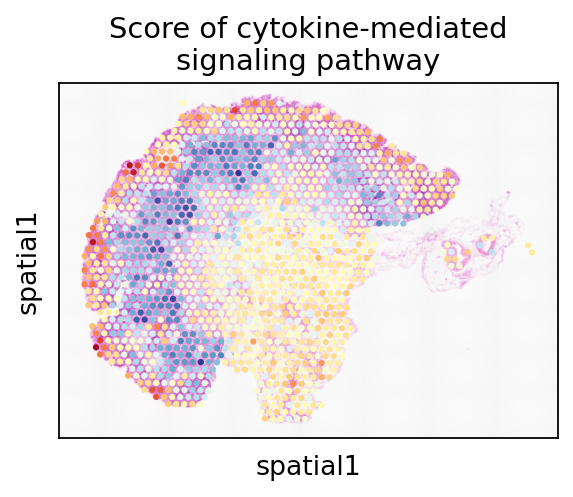

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt



pathway_dict=ov.utils.geneset_prepare(
    'Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')

sc.tl.score_genes(adata_spatial, pathway_dict['cytokine-mediated signaling pathway (GO:0019221)'], score_name='Score of cytokine-mediated\nsignaling pathway')
sc.tl.score_genes(adata_spatial_part, pathway_dict['cytokine-mediated signaling pathway (GO:0019221)'], score_name='Score of cytokine-mediated\nsignaling pathway')

fig, ax = plt.subplots(figsize=(4, 4))

ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=['Score of cytokine-mediated\nsignaling pathway'],colorbar_loc=None,
                  ncols=3, spot_size=224.5717/1.35,outline_width=0.02,legend_loc=None,legend_fontsize=12,
                  img_key='lowres',ax=ax,show=False
                 )
ax[0].set_title('Score of cytokine-mediated\nsignaling pathway', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial1', fontsize=12)

fig.savefig(f'Gastric/Figure/Spatial_main/Cytokine_mediated_pathway.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
adata_spatial_part

AnnData object with n_obs × n_vars = 780 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'uniform_density', 'rna_count_based_density', 'Epithelial cell', 'B cell(Plasma cell)', 'B cell', 'Endocrine cell', 'Myeloid cell', 'Mast cell', 'Fibroblast', 'NK/T cell', 'Smooth muscle cell', 'Endothelial cell', 'Neutrophil', 'Score of epithelial structure maintenance pathway', 'CD8_Tex', 'CD8_MAIT', 'CD4_Th17', 'CD4_Treg', 'Exhuasted Score', 'Score of cytokine-mediated\nsignaling pathway'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'robust', 'means', 'variances', 'residual_vari

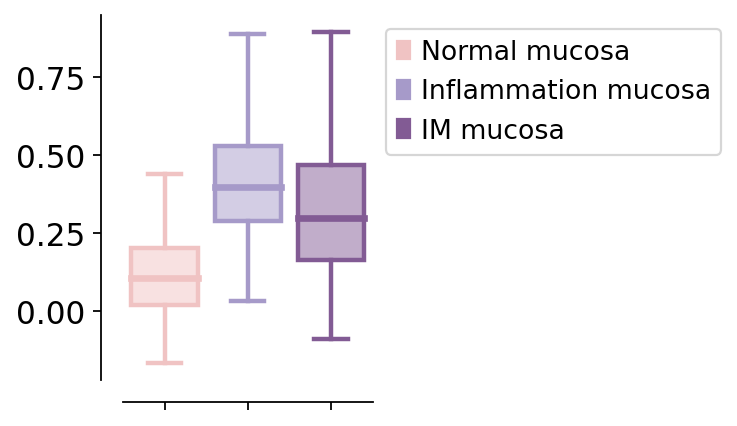

In [32]:
import pandas as pd
import seaborn as sns
#sns.set_style('white')

ov.pl.single_group_boxplot(adata_spatial_part,groupby='spatial domain',
             color='Score of cytokine-mediated\nsignaling pathway',
             type_color_dict=dict(zip(pd.Categorical(adata_spatial_part.obs['spatial domain']).categories,
                                      adata_spatial_part.uns['spatial domain_colors'])),
             x_ticks_plot=False,
             figsize=(2,3),
             kruskal_test=False,
             ylabel='',
             legend_plot=True,
             bbox_to_anchor=(1,1),
             title='',
             scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'},
             point_number=0,
             sort=False,
             save=False,
             )
plt.grid(False)
plt.xticks(rotation=90,fontsize=12)
plt.savefig(f'Gastric/Figure/Spatial_main/Cytokine_mediated_pathway_boxplot.png', dpi=300, bbox_inches='tight')


computing score 'Cytokine-cytokine receptor interaction score'
       'IFNA10', 'CCL4L1', 'CSH1', 'CCL3L3', 'EPOR'],
      dtype='object')
    finished: added
    'Cytokine-cytokine receptor interaction score', score of gene set (adata.obs).
    1184 total control genes are used. (0:00:00)
computing score 'Cytokine-cytokine receptor interaction score'
       'IFNA10', 'CCL4L1', 'CSH1', 'CCL3L3', 'EPOR'],
      dtype='object')
    finished: added
    'Cytokine-cytokine receptor interaction score', score of gene set (adata.obs).
    1179 total control genes are used. (0:00:00)


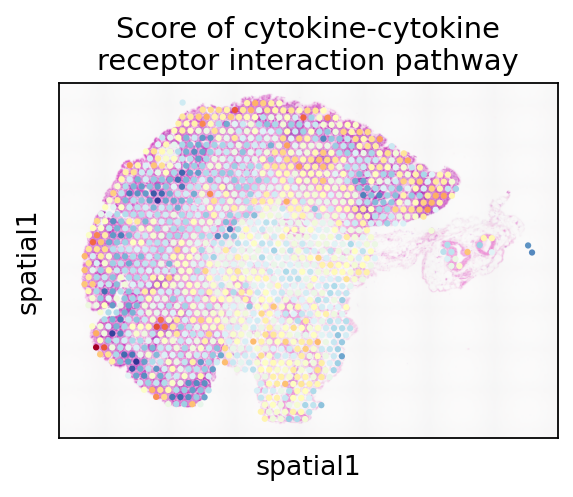

In [35]:
pathway_dict=ov.utils.geneset_prepare('Gastric/Reference/genesets/KEGG_2021_Human.txt',organism='Human')
sc.tl.score_genes(adata_spatial, pathway_dict['Cytokine-cytokine receptor interaction'], score_name = 'Cytokine-cytokine receptor interaction'+' score')
sc.tl.score_genes(adata_spatial_part, pathway_dict['Cytokine-cytokine receptor interaction'], score_name = 'Cytokine-cytokine receptor interaction'+' score')

fig, ax = plt.subplots(figsize=(4, 4))

ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=['Cytokine-cytokine receptor interaction score'],colorbar_loc=None,
                  ncols=3, spot_size=224.5717/1.35,outline_width=0.02,legend_loc=None,legend_fontsize=12,
                  img_key='lowres',ax=ax,show=False
                 )
ax[0].set_title('Score of cytokine-cytokine\nreceptor interaction pathway', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial1', fontsize=12)

fig.savefig(f'Gastric/Figure/Spatial_main/Cytokine_cytokine_pathway.png', dpi=300, bbox_inches='tight')


plt.show()



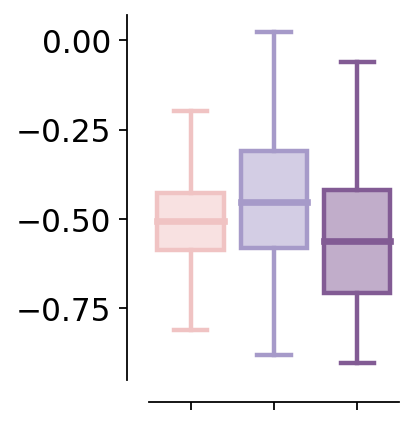

In [36]:
import pandas as pd
import seaborn as sns
#sns.set_style('white')

ov.pl.single_group_boxplot(adata_spatial_part,groupby='spatial domain',
             color='Cytokine-cytokine receptor interaction score',
             type_color_dict=dict(zip(pd.Categorical(adata_spatial_part.obs['spatial domain']).categories,
                                      adata_spatial_part.uns['spatial domain_colors'])),
             x_ticks_plot=False,
             figsize=(2,3),
             kruskal_test=False,
             ylabel='',
             legend_plot=False,
             bbox_to_anchor=(1,1),
             title='',
             scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'},
             point_number=0,
             sort=False,
             save=False,
             )
plt.grid(False)
plt.xticks(rotation=90,fontsize=12)
plt.savefig(f'Gastric/Figure/Spatial_main/Cytokine_cytokine_pathway_boxplot.png', dpi=300, bbox_inches='tight')


# epithelial cell

computing score 'Score of epithelial structure maintenance pathway'
    finished: added
    'Score of epithelial structure maintenance pathway', score of gene set (adata.obs).
    598 total control genes are used. (0:00:00)


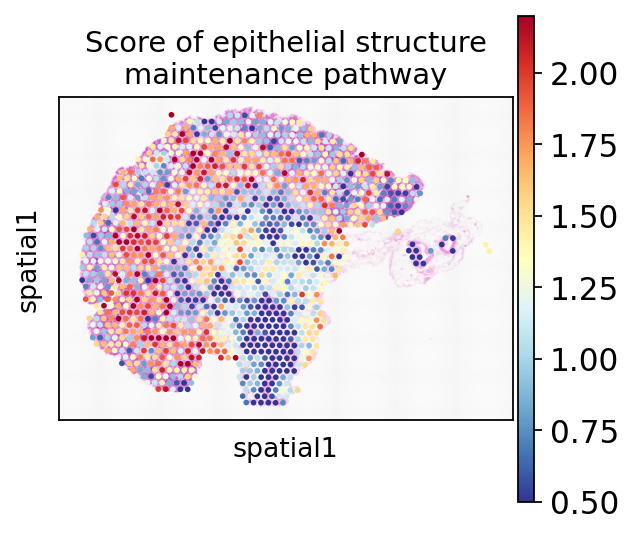

In [39]:
import scanpy as sc
import matplotlib.pyplot as plt



pathway_dict=ov.utils.geneset_prepare(
    'Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')

sc.tl.score_genes(adata_spatial, pathway_dict['epithelial structure maintenance (GO:0010669)'],
                  score_name='Score of epithelial structure maintenance pathway')

fig, ax = plt.subplots(figsize=(4, 4))

ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=['Score of epithelial structure maintenance pathway'],
                  ncols=3, spot_size=224.5717/1.35,outline_width=0.02,vmin=0.5,vmax=2.2,
                #   legend_loc=None,
                   legend_fontsize=12,
                  img_key='lowres',ax=ax,show=False
                 )
ax[0].set_title('Score of epithelial structure\nmaintenance pathway', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial1', fontsize=12)

fig.savefig(f'Gastric/Figure/Spatial_main/Epithelial_structure_pathway.png', dpi=300, bbox_inches='tight')

plt.show()

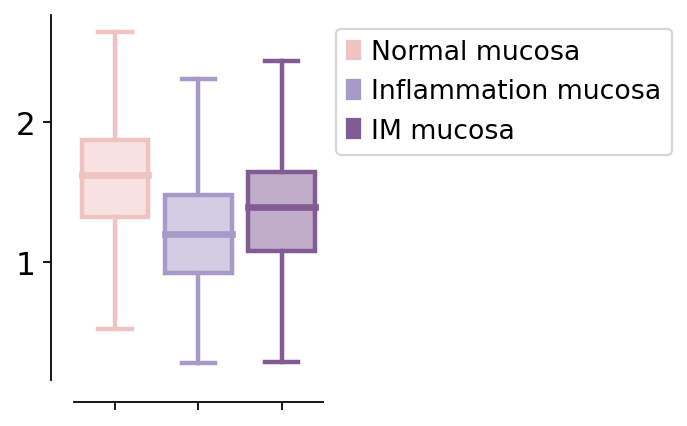

In [40]:
import pandas as pd
import seaborn as sns
#sns.set_style('white')

ov.pl.single_group_boxplot(adata_spatial_part,groupby='spatial domain',
             color='Score of epithelial structure maintenance pathway',
             type_color_dict=dict(zip(pd.Categorical(adata_spatial_part.obs['spatial domain']).categories,
                                      adata_spatial_part.uns['spatial domain_colors'])),
             x_ticks_plot=False,
             figsize=(2,3),
             kruskal_test=False,
             ylabel='',
             legend_plot=True,
             bbox_to_anchor=(1,1),
             title='',
             scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'},
             point_number=0,
             sort=False,
             save=False,
             )
plt.grid(False)
plt.xticks(rotation=90,fontsize=12)
plt.savefig(f'Gastric/Figure/Spatial_main/chylomicron_nassembly_boxplot.png', dpi=300, bbox_inches='tight')


computing score 'Score of chylomicron assembly pathway'
    finished: added
    'Score of chylomicron assembly pathway', score of gene set (adata.obs).
    348 total control genes are used. (0:00:00)


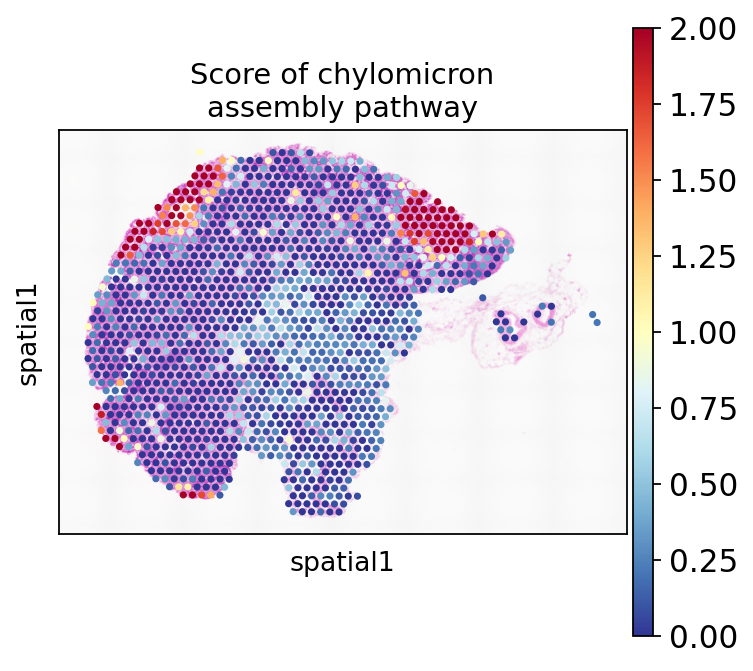

In [41]:
import scanpy as sc
import matplotlib.pyplot as plt




pathway_dict=ov.utils.geneset_prepare(
    'Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')

sc.tl.score_genes(adata_spatial, pathway_dict['chylomicron assembly (GO:0034378)'],
                  score_name='Score of chylomicron assembly pathway')


fig, ax = plt.subplots(figsize=(5, 5))

ax = sc.pl.spatial(adata_spatial, cmap='RdYlBu_r',
                  color=['Score of chylomicron assembly pathway'],
                  ncols=3, spot_size=224.5717/1.35,outline_width=1.02,vmin=0,vmax=2,
                #   legend_loc=None,
                   legend_fontsize=12,
                  img_key='lowres',ax=ax,show=False
                 )
ax[0].set_title('Score of chylomicron\nassembly pathway', fontsize=13)
ax[0].set_xlabel('spatial1', fontsize=12)
ax[0].set_ylabel('spatial1', fontsize=12)


fig.savefig(f'Gastric/Figure/Spatial_main/Chylomicron_assembly_pathway.png', dpi=300, bbox_inches='tight')


plt.show()

In [42]:
set(adata_spatial.obs['spatial domain'])
adata_spatial_part = adata_spatial[adata_spatial.obs['spatial domain'].isin(['Inflammation mucosa','Normal mucosa','IM mucosa','Cancer region'])]
adata_spatial_part

View of AnnData object with n_obs × n_vars = 805 × 2000
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'array_row', 'array_col', 'spatial domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'uniform_density', 'rna_count_based_density', 'Epithelial cell', 'B cell(Plasma cell)', 'B cell', 'Endocrine cell', 'Myeloid cell', 'Mast cell', 'Fibroblast', 'NK/T cell', 'Smooth muscle cell', 'Endothelial cell', 'Neutrophil', 'Score of epithelial structure maintenance pathway', 'CD8_Tex', 'CD8_MAIT', 'CD4_Th17', 'CD4_Treg', 'Exhuasted Score', 'Score of cytokine-mediated\nsignaling pathway', 'Cytokine-cytokine receptor interaction score', 'Score of chylomicron assembly pathway'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout

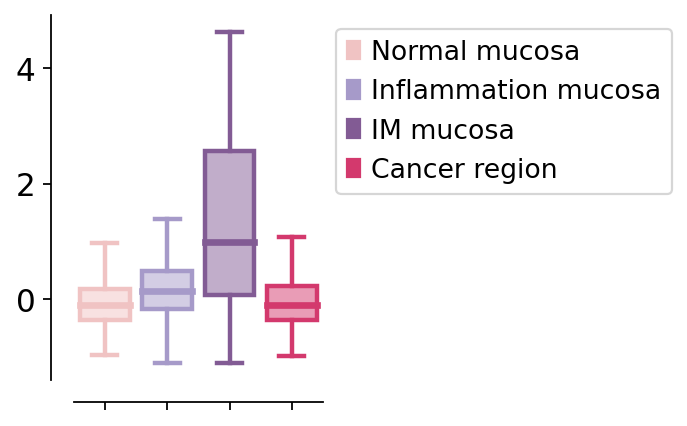

In [43]:
import pandas as pd
import seaborn as sns
#sns.set_style('white')

ov.pl.single_group_boxplot(adata_spatial_part,groupby='spatial domain',
             color='Score of chylomicron assembly pathway',
             type_color_dict=dict(zip(pd.Categorical(adata_spatial_part.obs['spatial domain']).categories,
                                      adata_spatial_part.uns['spatial domain_colors'])),
             x_ticks_plot=False,
             figsize=(2,3),
             kruskal_test=False,
             ylabel='',
             legend_plot=True,
             bbox_to_anchor=(1,1),
             title='',
             scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'},
             point_number=0,
             sort=False,
             save=False,
             )
plt.grid(False)
plt.xticks(rotation=90,fontsize=12)
plt.savefig(f'Gastric/Figure/Spatial_main/chylomicron_nassembly_boxplot.png', dpi=300, bbox_inches='tight')
